In [59]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sb

# Correlational Study

In [2]:
positive_words = [
    'wealthy',
    'powerful',
    'diverse',
    'happy',
    'beautiful',
    'proud',
    'innovative',
    'strong',
    'bravery',
    'family',
    'openness',
    'independence',
    'justice',
    'safety',
    'leader',
    'opportunity'
]

neutral_words = [
    'capitalist',
    'politics',
    'western',
    'constitution',
    'state',
    'people',
    'ocean',
    'military',
    'mountain',
    'city',
    'land',
    'president',
    'coast',
    'life',
    'eagle',
    'work'
]

negative_words = [
    'unequal',
    'broken',
    'angry',
    'unfair',
    'dangerous',
    'sad',
    'expensive',
    'ignorant',
    'greed',
    'racism',
    'oppression',
    'corruption',
    'obesity',
    'violence',
    'injustice',
    'drugs',
]

words = positive_words + neutral_words + negative_words

In [3]:
# Helper Functions

def get_vecs(row, order='first', w=words):
        
        ur_words = set()
        
        for n in range(1,7):
            
            search = order+"_"+str(n)
            
            for i in row[search].split(','):
                ur_words.add(i)
        
        return np.array([int(word in ur_words) for word in w])
    
def get_percent_agree(i, j):
    return ((list(i-j).count(0))/len(i))

def get_generalized_outgroup(row, w=words):
    go = get_vecs(row, order='mp', w=w)
    
    if row['pid3'] == 'Democrat':
        o = get_vecs(row, 'pubs', w=w)
    elif row['pid3'] == 'Republican':
        o = get_vecs(row, 'dems', w=w)
        
    return 1 - get_percent_agree(go,o)

def get_personal_outgroup(row, w=words):
    p = get_vecs(row, w=w)
    
    if row['pid3'] == 'Democrat':
        o = get_vecs(row, 'pubs', w=w)
    elif row['pid3'] == 'Republican':
        o = get_vecs(row, 'dems', w=w)
    
    return 1 - get_percent_agree(p,o)

def get_personal_ingroup(row, w=words):
    p = get_vecs(row, w=w)
    
    if row['pid3'] == 'Democrat':
        i = get_vecs(row, 'dems',w=w)
    elif row['pid3'] == 'Republican':
        i = get_vecs(row, 'pubs', w=w)
        
    return 1 - get_percent_agree(p, i)

def get_intergroup(row, w=words):
    
    d = get_vecs(row,order="dems", w=w)
    r = get_vecs(row,order="pubs", w=w)
    
    return 1 - get_percent_agree(d, r)

def get_identify(row):
    
    x1 = {"Not at all": 1,
          "Not very important": 2,
          "Very important": 3,
          "Extremely important": 4}[row['sit_1']]
    x2 = {"Not at all": 1,
          "Not very well": 2,
          "Very well": 3,
          "Extremely well": 4}[row['sit_2']]
    x3 = {"Not at all": 1,
          "Very little": 2,
          "Somewhat": 3,
          "A great deal": 4}[row['sit_3']]
    x4 = {"Never": 1,
          "Rarely": 2,
          "Some of the time": 3,
          "All of the time": 4}[row['sit_4']]
    
    return np.mean([x1,x2,x3,x4])
    
def get_ideology(row):
    
    return {'Extremely liberal': 7,
            'Liberal': 6,
            'Slightly liberal': 5,
            'Moderate or middle of the road': 4,
            'Slightly conservative': 3,
            'Conservative': 2,
            'Extremely conservative': 1}[row['ideo7']]

def get_pid4(row):
    if row['pid3'] == 'Democrat':
        if row['strongid'] == 'Strong ${q://QID101/ChoiceGroup/SelectedChoices}':
            return 1
        elif row['strongid'] == 'Not very strong ${q://QID101/ChoiceGroup/SelectedChoices}':
            return 2
    elif row['pid3'] == 'Republican':
        if row['strongid'] == 'Strong ${q://QID101/ChoiceGroup/SelectedChoices}':
            return 4
        elif row['strongid'] == 'Not very strong ${q://QID101/ChoiceGroup/SelectedChoices}':
            return 3
    
def get_ap(row):
    if row['dem'] == 1:
        return row['therm_dems_1'] - row['therm_pubs_1']
    else:
        return row['therm_pubs_1'] - row['therm_dems_1']
      
def get_dehum(row):
    if row['dem'] == 1:
        return row['human_24'] - row['human_23']
    else:
        return row['human_23'] - row['human_24']
    
def get_region(s):
    south = {'Alabama', 'Arkansas','Delaware','Florida', 'Georgia','Kentucky','Louisiana','Maryland','Mississippi','North Carolina','Oklahoma',
            'South Carolina','Tennessee','Texas','Virginia','West Virginia'}
    west = {'Arizona', 'California', 'Colorado','Idaho','Montana','Nevada','New Mexico','Oregon','Utah','Washington','Wyoming'}
    east = {'Connecticut','Maine','Massachusetts','New Hampshire','New Jersey','New York','Pennsylvania',
           'Rhode Island','Vermont'}
    midwest = {'Illinois','Indiana','Iowa','Kansas','Michigan','Minnesota','Missouri','Nebraska','North Dakota','Ohio',
              'South Dakota','Wisconsin'}
    other= {'Alaska','Hawaii'}
    foreign = {'Phillipines', 'Vietnam'}
    if s in south:
        return 'south'
    elif s in west:
        return 'west'
    elif s in east:
        return 'east'
    elif s in midwest:
        return 'midwest'
    elif s in other:
        return 'other'
    elif s in foreign:
        return 'foreign'
    #else:
    #    print(s)
    #    return s
    
def get_race(x):
    if x['Ethnicity (Simplified)'] != "UNK":
        return x['Ethnicity (Simplified)']
    else:
        return {'White': 'White',
                'Black or African American': 'Black',
                'White,American Indian or Alaska Native': 'Mixed',
                'Asian': 'Asian'}[x['Q309']]
    
def standardize(x):
    return (x - x.mean())/x.std()

def alpha(data):
    
    data = data.dropna()
    df_corr = abs(data.corr()).to_numpy()
    N = data.shape[1]
    
    rs = df_corr[np.triu_indices(N, k = 1)]
        
    return (N * np.mean(rs) / (1 + (N - 1) * np.mean(rs)))

In [4]:
# Load the Data

df1 = pd.read_csv("CorrelationalStudyData.csv")
print(len(df1))
df1 = df1[df1.Progress == 100]
print(len(df1))
df1 = df1[df1['Duration (in seconds)'] >= df1['Duration (in seconds)'].median()/2]
print(len(df1))
df1 = df1[df1.pid3 != 'Independent']
df1 = df1[df1.pid3 != 'Some other third party (please specify)']
print(len(df1))
df1 = df1.reset_index(drop=True)

913
865
774
772


In [5]:
# Merging in Demographic Data from Prolific (Blinded PROLIFIC_IDs)

demo_df1 = pd.read_csv('CorrelationalDemos.csv')
df1 = demo_df1.merge(df1, how="right", on="participant_id")

In [6]:
# Interpretive Divergences
df1['generalized_outgroup'] = df1.apply(get_generalized_outgroup, axis=1)
df1['personal_outgroup'] = df1.apply(get_personal_outgroup, axis=1)
df1['personal_ingroup'] = df1.apply(get_personal_ingroup, axis=1)
df1['intergroup'] = df1.apply(get_intergroup, axis=1)
df1['personal_intergroup'] = df1['personal_outgroup'] - df1['personal_ingroup']

# Standardized Interpretive Divergences
df1['generalized_outgroup_norm'] = standardize(df1.generalized_outgroup)
df1['personal_outgroup_norm'] = standardize(df1.personal_outgroup)
df1['personal_ingroup_norm'] = standardize(df1.personal_ingroup)
df1['intergroup_norm'] = standardize(df1.intergroup)
df1['personal_intergroup'] = standardize(df1.personal_intergroup)

# Nominal Partisan Identities
df1['dem'] = df1.pid3.apply(lambda x: {'Democrat': 1, 'Republican': 0}[x])
df1['pid4'] = df1.apply(get_pid4, axis=1)
df1['sdem'] = df1['pid4'].apply(lambda x: 1 if x == 1 else 0)
df1['wdem'] = df1['pid4'].apply(lambda x: 1 if x == 2 else 0)
df1['wpub'] = df1['pid4'].apply(lambda x: 1 if x == 3 else 0)
df1['spub'] = df1['pid4'].apply(lambda x: 1 if x == 4 else 0)
df1['num_strong'] = df1.strongid.apply(lambda x: 0 if "Not" in x else 1)
df1['text_strong'] = df1.strongid.apply(lambda x: "Weak" if "Not very" in x else "Strong")

# Social Partisan Identity
df1['identify'] = df1.apply(get_identify, axis=1)
df1['party_identify'] = df1.apply(lambda x: x['identify'] if x['dem'] == 1 else (-1.0 * x['identify']),axis=1)

# Political Ideology
df1['ideology'] = df1.apply(get_ideology, axis=1)
df1['ideo_extreme'] = df1.ideology.apply(lambda x: abs(4 - x))
df1['extreme_con'] = df1.ideology.apply(lambda x: 1 if x == 1 else 0)

# Other Demographics
df1['region'] = df1.Q306.apply(get_region)
df1.rename(columns={"Q310": "religion"}, inplace=True)
df1['race'] = df1.apply(get_race,axis=1)

# Blatant Outgroup Dehumanization
df1['dehuman'] = df1.apply(get_dehum, axis=1)
df1['any_dehuman'] = df1.dehuman.apply(lambda x: int(x > 0))
          
# Affective Polarization
df1['ap'] = df1.apply(get_ap, axis=1)
df1['out_warm'] = df1.apply(lambda x: x.therm_dems_1 if x.dem==0 else x.therm_pubs_1, axis=1)

# Propositional Measures
k = {"Strongly disagree": 1,
     "Somewhat disagree": 2,
     "Neither agree nor disagree": 3,
     "Somewhat agree": 4,
     "Strongly agree": 5,
     np.nan: np.nan}

df1['out_prop_A'] = df1.apply(lambda x: k[x.Q301_4] if x.dem == 1 else k[x.Q301_5], axis=1)
df1['in_prop_A'] = df1.apply(lambda x: k[x.Q301_5] if x.dem == 1 else k[x.Q301_4], axis=1)
df1['diff_prop_A'] = df1.apply(lambda x: x.out_prop_A - x.in_prop_A, axis=1)

df1['out_prop_W'] = df1.apply(lambda x: k[x.Q302_4] if x.dem == 1 else k[x.Q302_5], axis=1)
df1['in_prop_W'] = df1.apply(lambda x: k[x.Q302_5] if x.dem == 1 else k[x.Q302_4], axis=1)
df1['diff_prop_W'] = df1.apply(lambda x: x.out_prop_W - x.in_prop_W, axis=1)

df1['prop'] = df1.apply(lambda x: np.mean([x.out_prop_A, x.out_prop_W]),axis=1)

In [7]:
# How related are affective polarization and outgroup dehumanization?

stats.pearsonr(df1.dehuman, df1.ap)

(0.5377752992653202, 4.454539340729727e-59)

In [8]:
# How related is our measure of outgroup dehumanization to an alternative?

def get_dehumB(row):
    if row['dem'] == 1:
        return row['human_23']
    else:
        return row['human_24']
    
df1['dehumB'] = df1.apply(get_dehumB, axis=1)

stats.pearsonr(df1.dehuman, df1.dehumB)

(-0.8267195272305428, 1.5966551129450232e-194)

In [9]:
# Reliability of propositional measures

round(alpha(df1[['out_prop_A','out_prop_W']]),2)

0.85

## Descriptive Statistics

In [10]:
for d in ['Sex', 'race', 'religion', 'region', 'pid3']:
    print(d)
    print('--------')
    print(df1.groupby(d).size()/len(df1))
    print()

Sex
--------
Sex
Female    0.514249
Male      0.485751
dtype: float64

race
--------
race
Asian    0.066062
Black    0.110104
Mixed    0.036269
Other    0.029793
White    0.757772
dtype: float64

religion
--------
religion
Agnostic (not sure if God exists)                                0.137306
Atheists (do not believe God exists)                             0.129534
Buddhism                                                         0.015544
Catholicism (including Roman Catholic)                           0.225389
Christian Orthodox                                               0.038860
Hinduism                                                         0.003886
Islam                                                            0.007772
Judaism                                                          0.024611
Mormonism                                                        0.010363
Other (please specify)                                           0.068653
Other Christianity (including non-den

In [11]:
df1.groupby('pid3').size()

pid3
Democrat      390
Republican    382
dtype: int64

In [12]:
# Information for Table 1

T1 = df1[['generalized_outgroup','dehuman','prop','dem','num_strong','ideo_extreme','extreme_con']]

print(round(T1.mean(),2),'\n')
print(round(T1.std(),2),'\n')
print(round(T1.corr(),2),'\n')

generalized_outgroup     0.40
dehuman                 19.07
prop                     3.39
dem                      0.51
num_strong               0.56
ideo_extreme             1.86
extreme_con              0.09
dtype: float64 

generalized_outgroup     0.12
dehuman                 29.09
prop                     1.14
dem                      0.50
num_strong               0.50
ideo_extreme             0.86
extreme_con              0.29
dtype: float64 

                      generalized_outgroup  dehuman  prop   dem  num_strong  \
generalized_outgroup                  1.00     0.19  0.30 -0.13        0.03   
dehuman                               0.19     1.00  0.42  0.16        0.32   
prop                                  0.30     0.42  1.00 -0.04        0.26   
dem                                  -0.13     0.16 -0.04  1.00        0.22   
num_strong                            0.03     0.32  0.26  0.22        1.00   
ideo_extreme                          0.05     0.25  0.20  0.14        0

In [13]:
# Follow-ups on the distribution of dehumanization
print(df1.dehuman.median())
print(round(len(df1[df1.human_23 == df1.human_24])/len(df1),2))
print(round(len(df1[(df1.human_23 == 100) & (df1.human_24 == 100)])/len(df1),2))

7.0
0.36
0.26


## Main Results

In [14]:
# Model 1

f1 = 'dehuman ~ generalized_outgroup_norm'
mod1 = sm.ols(f1, data=df1)
res1 = mod1.fit()
res1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     27.46
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           2.07e-07
Time:                        13:55:02   Log-Likelihood:                -3683.5
No. Observations:                 772   AIC:                             7371.
Df Residuals:                     770   BIC:                             7380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    19.0712      1.030     18.523      0.000      17.050      21.092
generalized_outgroup_norm     5.3987      1.030      5.240      0.000       3.376       7.421
==============================================================================
Omnibus:                       97.457   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.184
Skew:                           0.903   Prob(JB):                     5.98e-31
Kurtosis:                       4.033   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Model 2

f2 = f1 + ' + dem + num_strong + extreme_con + ideo_extreme'
mod2 = sm.ols(f2, data=df1)
res2 = mod2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     28.29
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           2.30e-26
Time:                        13:55:02   Log-Likelihood:                -3631.6
No. Observations:                 772   AIC:                             7275.
Df Residuals:                     766   BIC:                             7303.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.3648      2.431      0.973      0.331      -2.407       7.137
generalized_outgroup_norm     5.3766      0.979      5.493      0.000       3.455       7.298
dem                           8.4269      2.197      3.836      0.000       4.114      12.740
num_strong                   13.1991      2.323      5.683      0.000       8.640      17.759
extreme_con                   7.7561      4.045      1.918      0.056      -0.184      15.696
ideo_extreme                  2.3018      1.436      1.603      0.109      -0.518       5.121
==============================================================================
Omnibus:                       75.093   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.503
Skew:                           0.752   Prob(JB):                     9.10e-23
Kurtosis:                       3.946   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Model 3

f3 = f2 + ' + personal_outgroup_norm'
mod3 = sm.ols(f3, data=df1)
res3 = mod3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     23.55
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           1.27e-25
Time:                        13:55:02   Log-Likelihood:                -3631.5
No. Observations:                 772   AIC:                             7277.
Df Residuals:                     765   BIC:                             7310.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.4424      2.464      0.991      0.322      -2.395       7.280
generalized_outgroup_norm     5.2421      1.195      4.387      0.000       2.896       7.588
dem                           8.4304      2.198      3.835      0.000       4.115      12.746
num_strong                   13.1980      2.324      5.679      0.000       8.636      17.760
extreme_con                   7.7636      4.047      1.918      0.055      -0.181      15.709
ideo_extreme                  2.2590      1.454      1.554      0.121      -0.594       5.112
personal_outgroup_norm        0.2365      1.204      0.196      0.844      -2.127       2.600
==============================================================================
Omnibus:                       75.263   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.679
Skew:                           0.754   Prob(JB):                     8.33e-23
Kurtosis:                       3.943   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Model 4

f4 = f2 + ' + intergroup_norm'
mod4 = sm.ols(f4, data=df1)
res4 = mod4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     23.57
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           1.22e-25
Time:                        13:55:02   Log-Likelihood:                -3631.5
No. Observations:                 772   AIC:                             7277.
Df Residuals:                     765   BIC:                             7310.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5042      2.464      1.016      0.310      -2.332       7.341
generalized_outgroup_norm     5.1897      1.112      4.669      0.000       3.008       7.372
dem                           8.3516      2.208      3.782      0.000       4.016      12.687
num_strong                   13.1939      2.324      5.677      0.000       8.632      17.756
extreme_con                   7.8024      4.049      1.927      0.054      -0.146      15.751
ideo_extreme                  2.2464      1.445      1.554      0.121      -0.591       5.084
intergroup_norm               0.3948      1.110      0.356      0.722      -1.785       2.574
==============================================================================
Omnibus:                       75.038   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.368
Skew:                           0.752   Prob(JB):                     9.73e-23
Kurtosis:                       3.944   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# Model 5

f5 = f2 + ' + prop'
mod5 = sm.ols(f5, data=df1)
res5 = mod5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     43.69
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           5.83e-46
Time:                        13:55:02   Log-Likelihood:                -3569.9
No. Observations:                 769   AIC:                             7154.
Df Residuals:                     762   BIC:                             7186.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -23.9553      3.472     -6.899      0.000     -30.772     -17.139
generalized_outgroup_norm     2.6455      0.963      2.747      0.006       0.755       4.536
dem                           9.3566      2.076      4.508      0.000       5.282      13.431
num_strong                    8.9385      2.232      4.005      0.000       4.557      13.320
extreme_con                   6.6832      3.810      1.754      0.080      -0.796      14.163
ideo_extreme                  1.5516      1.354      1.146      0.252      -1.106       4.209
prop                          8.7719      0.875     10.026      0.000       7.054      10.489
==============================================================================
Omnibus:                       41.989   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.484
Skew:                           0.488   Prob(JB):                     8.95e-13
Kurtosis:                       3.883   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Table 2

summary_col([res1,res2,res3,res4,res5],stars=True, float_format='%.2f',
            regressor_order = ["generalized_outgroup_norm",
                              "personal_outgroup_norm",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
generalized_outgroup_norm,5.40***,5.38***,5.24***,5.19***,2.65***
,(1.03),(0.98),(1.20),(1.11),(0.96)
personal_outgroup_norm,,,0.24,,
,,,(1.20),,
intergroup_norm,,,,0.39,
,,,,(1.11),
prop,,,,,8.77***
,,,,,(0.87)
dem,,8.43***,8.43***,8.35***,9.36***
,,(2.20),(2.20),(2.21),(2.08)


In [20]:
print(19.07 + 5.40)

24.47


<Figure size 1800x1200 with 0 Axes>

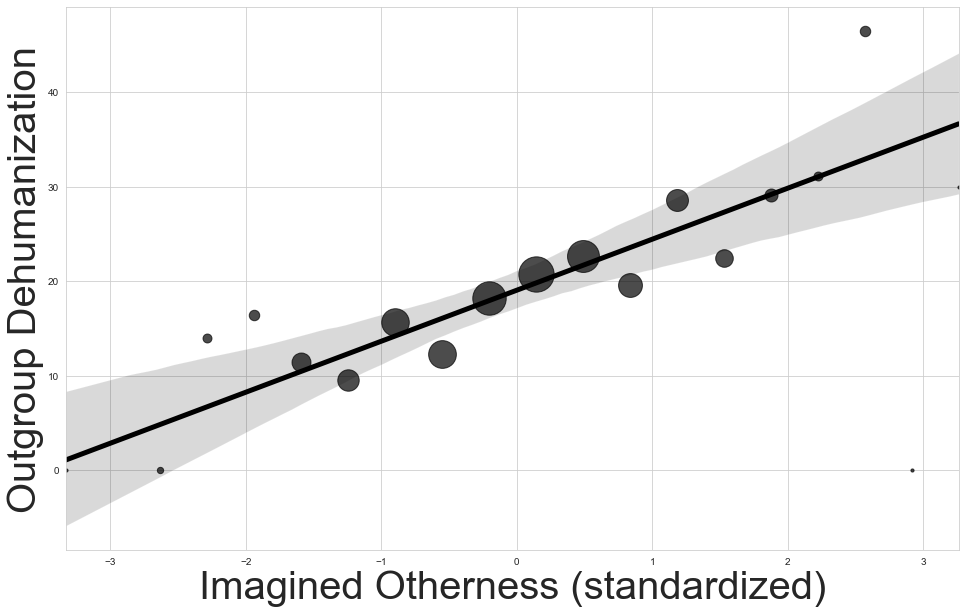

In [21]:
# Figure 4

plt.rc('font', size=24) 
plt.figure(dpi=300)
sb.set_style("whitegrid")

plt.figure(figsize=(16,10))

ax = sb.regplot(x='generalized_outgroup_norm',y='dehuman',
           scatter=False,
           line_kws={'lw':5, 'color':'black'},
           data=df1)

for x in set(df1.generalized_outgroup_norm):
    small_df = df1[df1.generalized_outgroup_norm == x]
    plt.scatter(x, small_df.dehuman.mean(), color="black", alpha=0.7,
                edgecolor="black", s=len(small_df)*10)

plt.ylabel("Outgroup Dehumanization", fontsize=40)
plt.xlabel("Imagined Otherness (standardized)", fontsize=40)

plt.show()

<Figure size 1800x1200 with 0 Axes>

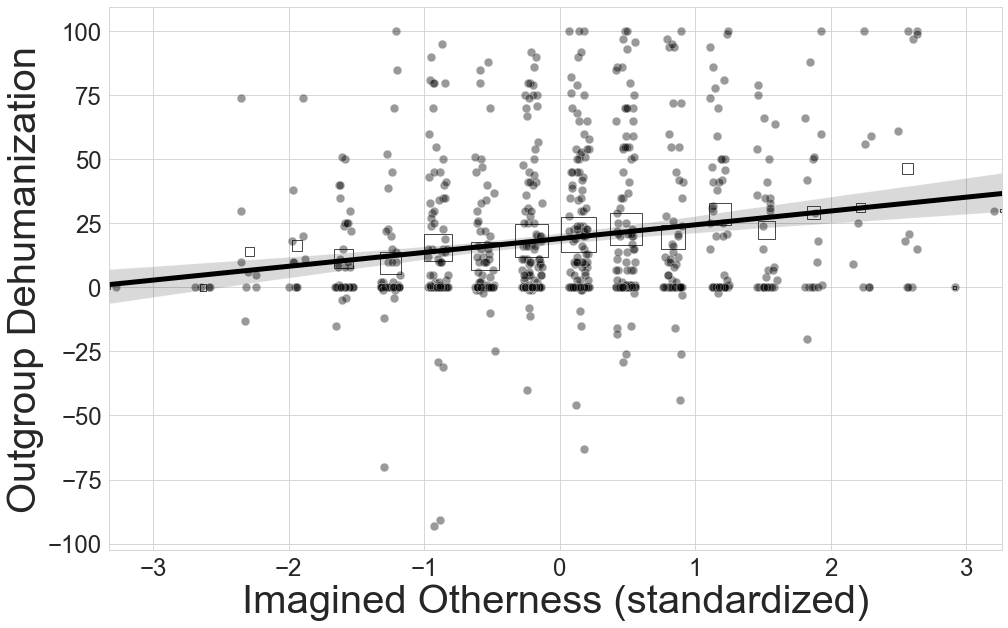

In [22]:
# Figure 4 with full scatter (w/ some noise added to imagined otherness for visibility)

plt.rc('font', size=24) 
plt.figure(dpi=300)
sb.set_style("whitegrid")

plt.figure(figsize=(16,10))

df1['io_noise'] = df1.generalized_outgroup_norm + np.random.uniform(-0.075, 0.075, size=len(df1))

sb.regplot(x='generalized_outgroup_norm',y='dehuman',
           scatter=False,
           line_kws={'lw':5, 'color':'black'},
           data=df1)

sb.scatterplot(x="io_noise", y="dehuman", data=df1, color="black", alpha=0.4, s=75)

for x in set(df1.generalized_outgroup_norm):
    small_df = df1[df1.generalized_outgroup_norm == x]
    plt.scatter(x, small_df.dehuman.mean(), facecolor='none', alpha=0.7,
                edgecolor="black", s=len(small_df)*10, marker="s")

plt.ylabel("Outgroup Dehumanization", fontsize=40)
plt.xlabel("Imagined Otherness (standardized)", fontsize=40)

plt.show()

## Robustness Tests

### Using single proposition measures

In [23]:
# Model 5B

f5b = f2 + ' + out_prop_A'
mod5b = sm.ols(f5b, data=df1)
res5b = mod5b.fit()
res5b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     38.23
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           1.12e-40
Time:                        13:55:03   Log-Likelihood:                -3591.2
No. Observations:                 771   AIC:                             7196.
Df Residuals:                     764   BIC:                             7229.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -19.0059      3.399     -5.591      0.000     -25.679     -12.333
generalized_outgroup_norm     3.0237      0.976      3.098      0.002       1.108       4.940
dem                           9.6235      2.108      4.566      0.000       5.486      13.761
num_strong                   10.0312      2.253      4.452      0.000       5.608      14.454
extreme_con                   7.4554      3.866      1.928      0.054      -0.134      15.045
ideo_extreme                  1.8149      1.374      1.321      0.187      -0.883       4.513
out_prop_A                    7.0209      0.819      8.572      0.000       5.413       8.629
==============================================================================
Omnibus:                       56.788   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.943
Skew:                           0.601   Prob(JB):                     1.96e-17
Kurtosis:                       3.975   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Model 5C

f5c = f2 + ' + out_prop_W'
mod5c = sm.ols(f5c, data=df1)
res5c = mod5c.fit()
res5c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                dehuman   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     42.44
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           9.10e-45
Time:                        13:55:03   Log-Likelihood:                -3577.3
No. Observations:                 770   AIC:                             7169.
Df Residuals:                     763   BIC:                             7201.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -20.7664      3.299     -6.295      0.000     -27.242     -14.291
generalized_outgroup_norm     3.0707      0.955      3.214      0.001       1.195       4.946
dem                           8.6615      2.078      4.167      0.000       4.581      12.742
num_strong                    9.1641      2.234      4.102      0.000       4.779      13.550
extreme_con                   6.0857      3.825      1.591      0.112      -1.423      13.595
ideo_extreme                  1.4992      1.358      1.104      0.270      -1.167       4.166
out_prop_W                    7.8482      0.805      9.751      0.000       6.268       9.428
==============================================================================
Omnibus:                       38.522   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.747
Skew:                           0.466   Prob(JB):                     1.58e-11
Kurtosis:                       3.826   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using Heteroskedasticity-robust Standard Errors

In [25]:
# Using White’s (1980) heteroskedasticity robust standard errors

cov="HC0"

res1r = mod1.fit(cov_type=cov)
res2r = mod2.fit(cov_type=cov)
res3r = mod3.fit(cov_type=cov)
res4r = mod4.fit(cov_type=cov)
res5r = mod5.fit(cov_type=cov)

summary_col([res1r,res2r,res3r,res4r,res5r],stars=True, float_format='%.2f',
            regressor_order = ["generalized_outgroup_norm",
                              "personal_outgroup_norm",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
generalized_outgroup_norm,5.40***,5.38***,5.24***,5.19***,2.65***
,(1.05),(0.98),(1.16),(1.03),(0.94)
personal_outgroup_norm,,,0.24,,
,,,(1.18),,
intergroup_norm,,,,0.39,
,,,,(0.94),
prop,,,,,8.77***
,,,,,(0.86)
dem,,8.43***,8.43***,8.35***,9.36***
,,(2.20),(2.20),(2.19),(2.04)


### Calculating Bootstrapped Standard Errors

In [26]:
def bootstrap_reg(f, data=df1, n_reps=10000):
    
    _betas = {}
    
    # For first run only, add coefficients to dict
    
    df_iter = df1.sample(frac=1, replace=True)
    m = sm.ols(f, data=df_iter)
    r = m.fit()
    
    for x, b in zip(r.params.index, r.params):
        _betas[x] = [b]
    
    for _ in range(n_reps-1):
        
        df_iter = df1.sample(frac=1, replace=True)
        m = sm.ols(f, data=df_iter)
        r = m.fit()
    
        for x, b in zip(r.params.index, r.params):
            _betas[x].append(b)
            
    return _betas


In [27]:
# Checking Model 1

np.random.seed(8675309)

betas = bootstrap_reg(f1)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [17.05092558 21.03271325]
99% CI:  [16.39591303 21.62025683]
99.9% CI:  [15.9130691  22.36097732]

generalized_outgroup_norm
95% CI:  [3.35247566 7.45407839]
99% CI:  [2.5948369  8.17360927]
99.9% CI:  [1.75009887 8.95891717]



In [28]:
# Checking Model 2

np.random.seed(8675309)

betas = bootstrap_reg(f2)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-2.08773955  6.83487855]
99% CI:  [-3.55322561  7.98670511]
99.9% CI:  [-5.24441339  9.56458371]

generalized_outgroup_norm
95% CI:  [3.42554543 7.27070724]
99% CI:  [2.77150318 7.87539713]
99.9% CI:  [2.05139651 8.77932737]

dem
95% CI:  [ 4.19454804 12.72221176]
99% CI:  [ 2.88836583 14.21962739]
99.9% CI:  [ 1.55156301 15.82492822]

num_strong
95% CI:  [ 8.86691525 17.67243519]
99% CI:  [ 7.40759065 18.87240924]
99.9% CI:  [ 5.82252366 20.15162814]

extreme_con
95% CI:  [-1.45162733 17.12523837]
99% CI:  [-4.21490534 19.70760784]
99.9% CI:  [-7.36147283 23.52168079]

ideo_extreme
95% CI:  [-0.6893934   5.29946664]
99% CI:  [-1.61232836  6.28837683]
99.9% CI:  [-2.50313064  7.16013607]



In [29]:
# Checking Model 3

np.random.seed(8675309)

betas = bootstrap_reg(f3)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-2.07716848  6.87657576]
99% CI:  [-3.42228564  8.18528173]
99.9% CI:  [-5.29381406  9.66546762]

generalized_outgroup_norm
95% CI:  [2.97454033 7.5201524 ]
99% CI:  [2.15989805 8.28334907]
99.9% CI:  [1.37164877 9.14302715]

dem
95% CI:  [ 4.19291845 12.71524734]
99% CI:  [ 2.88326462 14.23934469]
99.9% CI:  [ 1.63706168 15.83058809]

num_strong
95% CI:  [ 8.85227884 17.65607673]
99% CI:  [ 7.32384188 18.86285538]
99.9% CI:  [ 5.81800042 20.18791601]

extreme_con
95% CI:  [-1.41664111 17.15466698]
99% CI:  [-4.21366583 19.74372953]
99.9% CI:  [-7.49465804 23.78962306]

ideo_extreme
95% CI:  [-0.75074084  5.29025393]
99% CI:  [-1.66788445  6.26602679]
99.9% CI:  [-2.57257905  7.00176961]

personal_outgroup_norm
95% CI:  [-2.1287857   2.56843127]
99% CI:  [-2.93110751  3.27279155]
99.9% CI:  [-3.59674044  4.23998925]



In [30]:
# Checking Model 4

np.random.seed(8675309)

betas = bootstrap_reg(f4)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-1.95302568  6.96304628]
99% CI:  [-3.33335156  8.20598411]
99.9% CI:  [-5.29352112  9.68911114]

generalized_outgroup_norm
95% CI:  [3.12076959 7.20950554]
99% CI:  [2.49696863 7.91836779]
99.9% CI:  [1.71043152 8.69020529]

dem
95% CI:  [ 4.115219   12.62776743]
99% CI:  [ 2.81697266 14.03570329]
99.9% CI:  [ 1.40731392 15.70739575]

num_strong
95% CI:  [ 8.87142562 17.67596461]
99% CI:  [ 7.37116111 18.85537744]
99.9% CI:  [ 5.79699977 20.06019877]

extreme_con
95% CI:  [-1.40713408 17.17955127]
99% CI:  [-4.17491675 19.80986459]
99.9% CI:  [-7.34927245 23.69700002]

ideo_extreme
95% CI:  [-0.77931639  5.27429684]
99% CI:  [-1.70207464  6.25042581]
99.9% CI:  [-2.44699685  6.99132523]

intergroup_norm
95% CI:  [-1.50375179  2.28542361]
99% CI:  [-2.1290992   2.81475586]
99.9% CI:  [-2.74201227  3.54321608]



In [31]:
# Checking Model 5

np.random.seed(8675309)

betas = bootstrap_reg(f5)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-30.13905448 -18.02402834]
99% CI:  [-32.06039391 -15.97777295]
99.9% CI:  [-34.48917358 -14.1008292 ]

generalized_outgroup_norm
95% CI:  [0.77258553 4.47469834]
99% CI:  [0.16623627 5.07739922]
99.9% CI:  [-0.63110044  5.99307941]

dem
95% CI:  [ 5.37534785 13.31859872]
99% CI:  [ 4.23919034 14.71461571]
99.9% CI:  [ 3.23663202 16.20850264]

num_strong
95% CI:  [ 4.8843235  13.08704115]
99% CI:  [ 3.4335557  14.22480231]
99.9% CI:  [ 2.29299772 15.72488655]

extreme_con
95% CI:  [-2.15825672 15.81652739]
99% CI:  [-5.14280784 18.38934785]
99.9% CI:  [-8.0754376  21.61362604]

ideo_extreme
95% CI:  [-1.30150462  4.4245358 ]
99% CI:  [-2.12225013  5.25297146]
99.9% CI:  [-3.09258505  6.47714652]

prop
95% CI:  [ 7.06341544 10.48212415]
99% CI:  [ 6.54742972 11.04302464]
99.9% CI:  [ 5.9536913  11.68738357]



## Validating the Schema Elicitation Task

### Analysis A

In [32]:
# Calculate Cohen's D

m1 = df1.personal_ingroup.mean()
m2 = df1.personal_outgroup.mean()

pooled = pd.concat([df1.personal_ingroup, df1.personal_outgroup])

print((m2 - m1)/pooled.std())

1.0150922665648976


In [34]:
# Paired sample t test

stats.ttest_rel(df1.personal_outgroup, df1.personal_ingroup)

Ttest_relResult(statistic=22.640653960624014, pvalue=2.0733363768309447e-87)

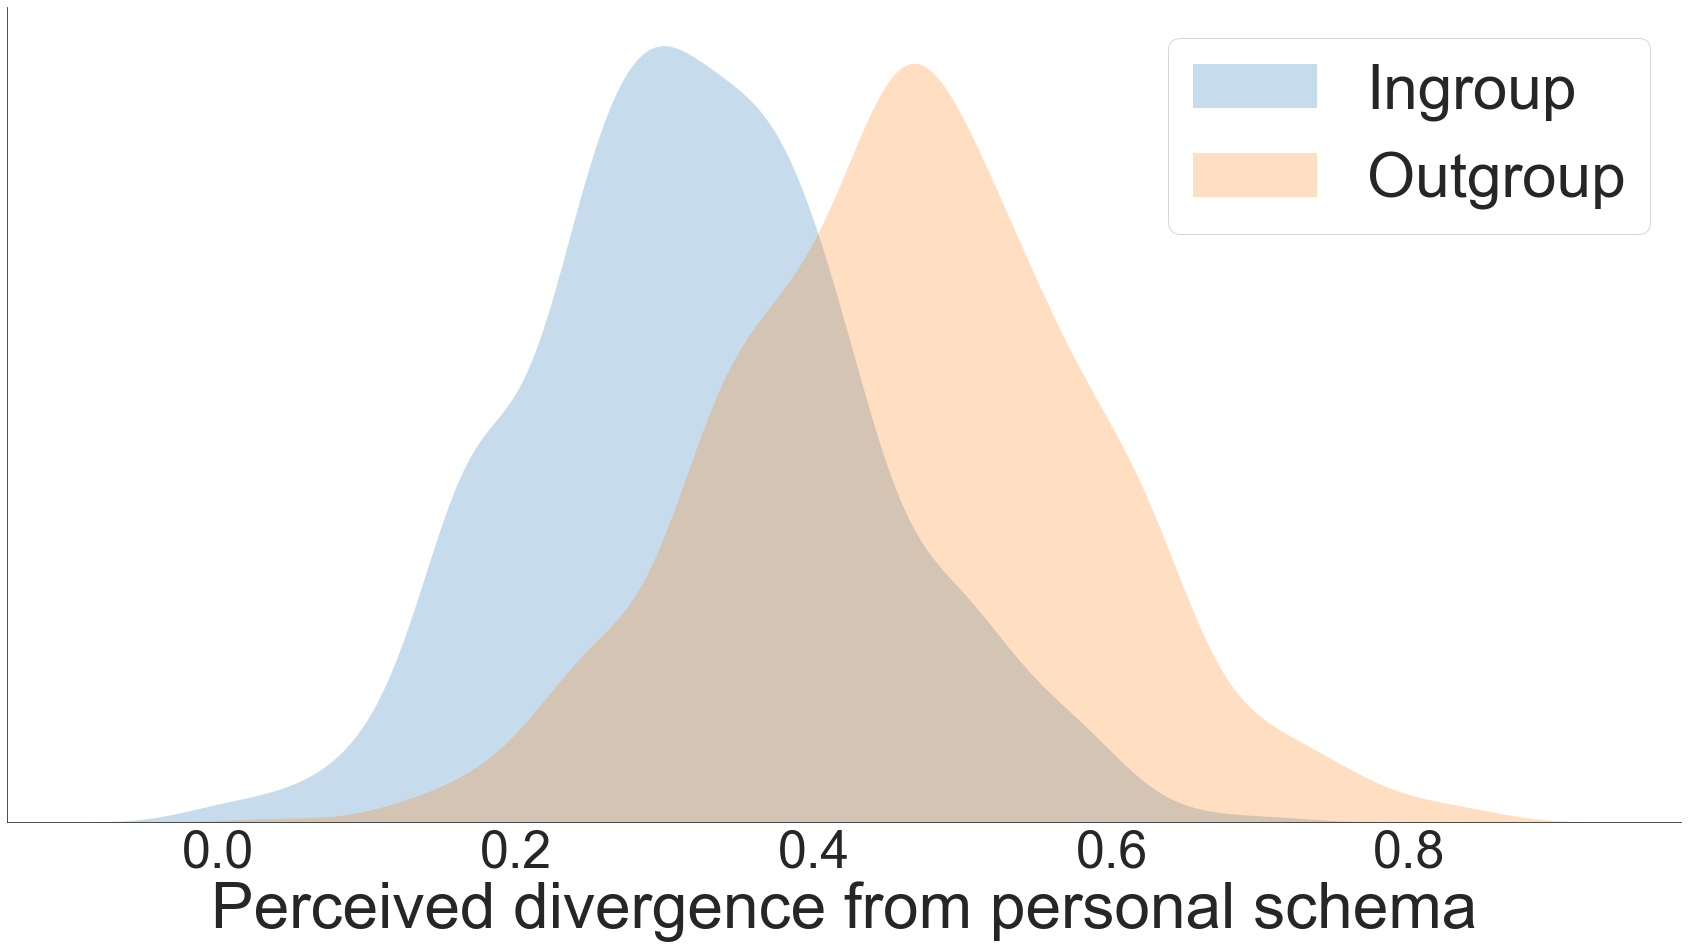

In [36]:
# Figure A1

sb.set_style("white")

fig, ax = plt.subplots(figsize=(30,15))

sb.kdeplot(df1.personal_ingroup, shade=True, label="Ingroup", linewidth=0)
sb.kdeplot(df1.personal_outgroup, shade = True, label="Outgroup", linewidth=0)
plt.legend(fontsize=62)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.ylabel('')
plt.xticks(None,None,fontsize=52)

plt.xlabel('Perceived divergence from personal schema',fontsize=64)

plt.show()

### Analysis B

In [37]:
# Relationship between social partisan identity strength and personal intergroup divergence

print(stats.spearmanr(df1.identify, df1.personal_intergroup))
print(stats.pearsonr(df1.identify, df1.personal_intergroup))

SpearmanrResult(correlation=0.15404076608531686, pvalue=1.7176211165989784e-05)
(0.14977409513789885, 2.936918761101236e-05)


In [38]:
# Nominal partisan identity and personal intergroup divergence

print(stats.ttest_ind(df1.personal_intergroup, df1.num_strong))
print(stats.ranksums(df1.personal_intergroup, df1.num_strong))

Ttest_indResult(statistic=-14.023970269179088, pvalue=3.838601152730864e-42)
RanksumsResult(statistic=-14.18718876602455, pvalue=1.0997994966774933e-45)


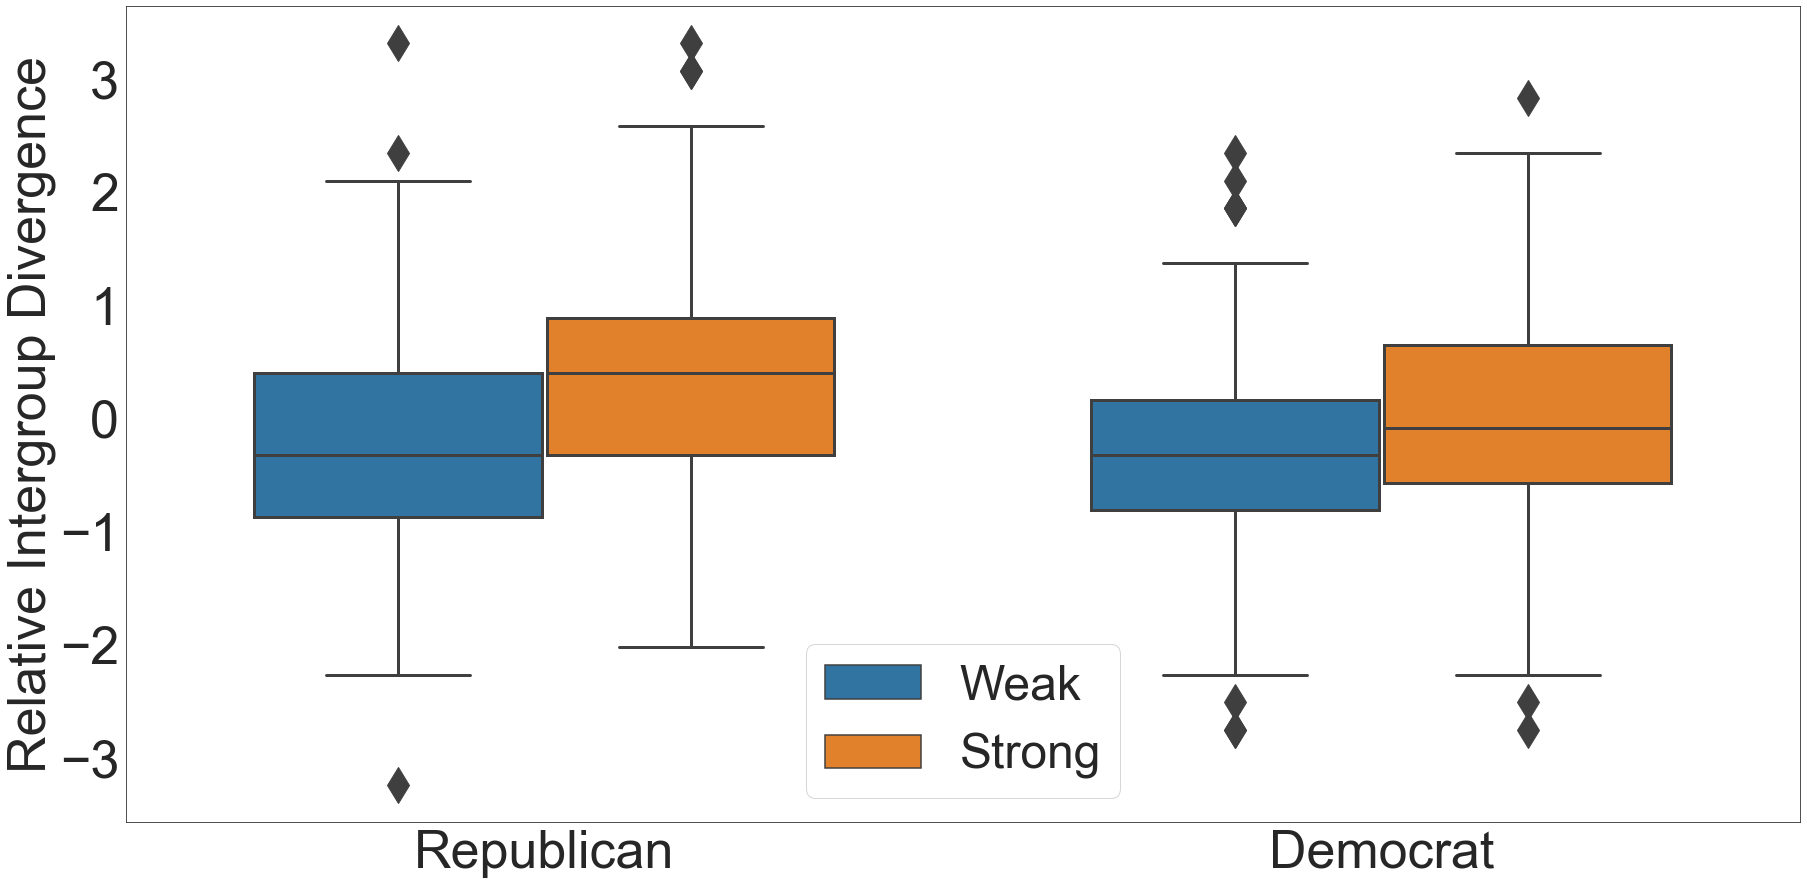

In [39]:
# Figure A2

plt.figure(figsize=(30,15))
sb.boxplot(x="dem", y="personal_intergroup", hue="text_strong", data=df1,
          fliersize=25, linewidth=3, whis=1.5, width=0.7)
plt.ylabel('Relative Intergroup Divergence', fontsize=52)
plt.yticks(None,None,fontsize=52)
plt.xticks([0,1],["Republican","Democrat"],fontsize=52)
plt.xlabel('')
plt.legend(fontsize=48)
plt.show()

### Analysis C

In [40]:
# Is outgroup warmth predicted by personal-outgroup divergence?

r1val = sm.ols('out_warm ~ personal_outgroup_norm', df1).fit()
r2val = sm.ols('out_warm ~ personal_outgroup_norm + dem + num_strong + ideo_extreme', df1).fit()

summary_col([r1val, r2val],stars=True, float_format='%.2f',
            regressor_order = ["personal_outgroup_norm",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,out_warm I,out_warm II
personal_outgroup_norm,-7.65***,-6.44***
,(0.80),(0.74)
dem,,-5.68***
,,(1.49)
num_strong,,-8.20***
,,(1.74)
ideo_extreme,,-6.30***
,,(1.00)
Intercept,27.58***,46.79***
,(0.80),(1.82)


## Empirical Extensions

### Heterogeneity Analysis

In [41]:
# Does the relationship between GO and dehumanization depend on PI? (Table A3)

r1app = sm.ols('dehuman ~ generalized_outgroup_norm + personal_ingroup_norm', df1).fit()
r2app = sm.ols('dehuman ~ generalized_outgroup_norm*personal_ingroup_norm', df1).fit()
r3app = sm.ols('dehuman ~ generalized_outgroup_norm*personal_ingroup_norm + dem + num_strong + extreme_con + ideo_extreme', df1).fit()

summary_col([r1app, r2app, r3app],stars=True, float_format='%.2f',
            regressor_order = ["generalized_outgroup_norm",
                              "personal_ingroup_norm",
                              "generalized_outgroup_norm:personal_ingroup_norm",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III
generalized_outgroup_norm,5.53***,4.92***,4.78***
,(1.03),(1.06),(1.01)
personal_ingroup_norm,-2.20**,-2.14**,-0.15
,(1.03),(1.03),(1.00)
generalized_outgroup_norm:personal_ingroup_norm,,-2.21**,-2.37**
,,(0.98),(0.92)
dem,,,8.63***
,,,(2.19)
num_strong,,,13.47***
,,,(2.35)


In [42]:
# Replicating Table A3 with robust standard errors

r1app = sm.ols('dehuman ~ generalized_outgroup_norm + personal_ingroup_norm', df1).fit(cov="HC0")
r2app = sm.ols('dehuman ~ generalized_outgroup_norm*personal_ingroup_norm', df1).fit(cov="HC0")
r3app = sm.ols('dehuman ~ generalized_outgroup_norm*personal_ingroup_norm + dem + num_strong + extreme_con + ideo_extreme', df1).fit(cov="HC0")

summary_col([r1app, r2app, r3app],stars=True, float_format='%.2f',
            regressor_order = ["generalized_outgroup_norm",
                              "personal_ingroup_norm",
                              "generalized_outgroup_norm:personal_ingroup_norm",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III
generalized_outgroup_norm,5.53***,4.92***,4.78***
,(1.03),(1.06),(1.01)
personal_ingroup_norm,-2.20**,-2.14**,-0.15
,(1.03),(1.03),(1.00)
generalized_outgroup_norm:personal_ingroup_norm,,-2.21**,-2.37**
,,(0.98),(0.92)
dem,,,8.63***
,,,(2.19)
num_strong,,,13.47***
,,,(2.35)


In [43]:
# Replicating model 3 of Table A3 with bootstrapped CIs

np.random.seed(8675309)

betas = bootstrap_reg('dehuman ~ generalized_outgroup_norm*personal_ingroup_norm + dem + num_strong + extreme_con + ideo_extreme')

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-1.81803926  7.13702734]
99% CI:  [-3.216849    8.45725635]
99.9% CI:  [-4.93206709  9.90892331]

generalized_outgroup_norm
95% CI:  [2.82970727 6.71902187]
99% CI:  [2.19473593 7.37146867]
99.9% CI:  [1.47776849 8.0354801 ]

personal_ingroup_norm
95% CI:  [-2.16052631  1.92778946]
99% CI:  [-2.76864123  2.5270308 ]
99.9% CI:  [-3.47920778  3.23260147]

generalized_outgroup_norm:personal_ingroup_norm
95% CI:  [-4.05913634 -0.70387921]
99% CI:  [-4.58969708 -0.1211026 ]
99.9% CI:  [-5.3247001  0.5664825]

dem
95% CI:  [ 4.40727914 12.93768238]
99% CI:  [ 3.03782203 14.32615336]
99.9% CI:  [ 1.86666017 15.90342915]

num_strong
95% CI:  [ 8.98349691 18.0906182 ]
99% CI:  [ 7.36306277 19.29987229]
99.9% CI:  [ 5.96498474 20.52856895]

extreme_con
95% CI:  [-2.08535202 16.2881563 ]
99% CI:  [-4.63326676 19.08737572]
99.9% CI:  [-7.54192195 22.31327721]

ideo_extreme
95% CI:  [-0.90465907  5.13577233]
99% CI:  [-1.89045221  6.10077867]
99.9% CI:  [-2.72799801  7.09240774]

### Content Analysis

In [44]:
# Analysis using only Positive words

df1['go_pos'] = df1.apply(get_generalized_outgroup, args=([positive_words]), axis=1)

f1p = 'dehuman ~ go_pos'
f2p = f1p + ' + dem + num_strong + extreme_con + ideo_extreme'
f3p = f2p + ' + personal_outgroup_norm'
f4p = f2p + ' + intergroup_norm'
f5p = f2p + ' + prop'

m1p = sm.ols(f1p, data=df1)
m2p = sm.ols(f2p, data=df1)
m3p = sm.ols(f3p, data=df1)
m4p = sm.ols(f4p, data=df1)
m5p = sm.ols(f5p, data=df1)

r1p = m1p.fit()
r2p = m2p.fit()
r3p = m3p.fit()
r4p = m4p.fit()
r5p = m5p.fit()

summary_col([r1p,r2p,r3p,r4p,r5p],stars=True, float_format='%.2f',
            regressor_order = ["go_pos",
                              "personal_outgroup_norm",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
go_pos,17.39***,17.89***,12.05*,13.88**,6.06
,(6.47),(6.13),(6.60),(6.41),(5.84)
personal_outgroup_norm,,,2.52**,,
,,,(1.08),,
intergroup_norm,,,,2.18**,
,,,,(1.04),
prop,,,,,9.29***
,,,,,(0.86)
dem,,7.98***,8.09***,7.63***,9.11***
,,(2.23),(2.23),(2.23),(2.09)


In [45]:
# Analysis using only Neutral words

df1['go_neu'] = df1.apply(get_generalized_outgroup, args=([neutral_words]), axis=1)

f1n = 'dehuman ~ go_neu'
f2n = f1n + ' + dem + num_strong + extreme_con + ideo_extreme'
f3n = f2n + ' + personal_outgroup_norm'
f4n = f2n + ' + intergroup_norm'
f5n = f2n + ' + prop'

m1n = sm.ols(f1n, data=df1)
m2n = sm.ols(f2n, data=df1)
m3n = sm.ols(f3n, data=df1)
m4n = sm.ols(f4n, data=df1)
m5n = sm.ols(f5n, data=df1)

r1n = m1n.fit()
r2n = m2n.fit()
r3n = m3n.fit()
r4n = m4n.fit()
r5n = m5n.fit()

summary_col([r1n,r2n,r3n,r4n,r5n],stars=True, float_format='%.2f',
            regressor_order = ["go_neu",
                              "personal_outgroup_norm",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
go_neu,26.17***,30.74***,28.01***,28.90***,18.34***
,(5.88),(5.59),(6.22),(6.12),(5.39)
personal_outgroup_norm,,,1.10,,
,,,(1.10),,
intergroup_norm,,,,0.80,
,,,,(1.07),
prop,,,,,8.82***
,,,,,(0.86)
dem,,9.16***,9.14***,8.97***,9.93***
,,(2.21),(2.21),(2.23),(2.09)


In [46]:
# Analysis using only Negative words

df1['go_neg'] = df1.apply(get_generalized_outgroup, args=([negative_words]), axis=1)

f1neg = 'dehuman ~ go_neg'
f2neg = f1neg + ' + dem + num_strong + extreme_con + ideo_extreme'
f3neg = f2neg + ' + personal_outgroup_norm'
f4neg = f2neg + ' + intergroup_norm'
f5neg = f2neg + ' + prop'

m1neg = sm.ols(f1neg, data=df1)
m2neg = sm.ols(f2neg, data=df1)
m3neg = sm.ols(f3neg, data=df1)
m4neg = sm.ols(f4neg, data=df1)
m5neg = sm.ols(f5neg, data=df1)

r1neg = m1neg.fit()
r2neg = m2neg.fit()
r3neg = m3neg.fit()
r4neg = m4neg.fit()
r5neg = m5neg.fit()

summary_col([r1neg,r2neg,r3neg,r4neg,r5neg],stars=True, float_format='%.2f',
            regressor_order = ["go_neg",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
go_neg,22.94***,17.71***,12.17*,14.05**,6.60
,(6.02),(5.74),(6.25),(6.00),(5.48)
intergroup_norm,,,,2.13**,
,,,,(1.04),
prop,,,,,9.27***
,,,,,(0.86)
dem,,6.76***,7.25***,6.68***,8.68***
,,(2.22),(2.22),(2.22),(2.08)
num_strong,,13.64***,13.50***,13.52***,8.87***
,,(2.35),(2.35),(2.35),(2.24)


In [47]:
# Analysis comparing Positive, Neutral, and Negative terms
f1abl = 'dehuman ~ go_pos + go_neu + go_neg'
f2abl = f1abl + ' + dem + num_strong + extreme_con + ideo_extreme'
f3abl = f2abl + ' + personal_outgroup_norm'
f4abl = f2abl + ' + intergroup_norm'
f5abl = f2abl + ' + prop'

m1abl = sm.ols(f1abl, data=df1)
m2abl = sm.ols(f2abl, data=df1)
m3abl = sm.ols(f3abl, data=df1)
m4abl = sm.ols(f4abl, data=df1)
m5abl = sm.ols(f5abl, data=df1)

r1abl = m1abl.fit()
r2abl = m2abl.fit()
r3abl = m3abl.fit()
r4abl = m4abl.fit()
r5abl = m5abl.fit()

summary_col([r1abl,r2abl,r3abl,r4abl,r5abl],stars=True, float_format='%.2f',
            regressor_order = ["go_pos",
                               "go_neu",
                               "go_neg",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
go_pos,4.68,5.26,5.15,5.16,-0.73
,(6.93),(6.52),(6.69),(6.59),(6.18)
go_neu,21.62***,27.03***,26.87***,26.82***,17.94***
,(6.27),(5.96),(6.34),(6.30),(5.70)
go_neg,18.12***,11.46*,11.32*,11.33*,3.97
,(6.17),(5.86),(6.20),(6.01),(5.59)
intergroup_norm,,,,0.12,
,,,,(1.11),
prop,,,,,8.73***
,,,,,(0.87)


In [48]:
# Table A4

f1abl = 'dehuman ~ go_pos + go_neu + go_neg'
f2abl = f1abl + ' + dem + num_strong + extreme_con + ideo_extreme'
f3abl = f2abl + ' + personal_outgroup_norm'
f4abl = f2abl + ' + intergroup_norm'
f5abl = f2abl + ' + prop'

m1abl = sm.ols(f1abl, data=df1)
m2abl = sm.ols(f2abl, data=df1)
m3abl = sm.ols(f3abl, data=df1)
m4abl = sm.ols(f4abl, data=df1)
m5abl = sm.ols(f5abl, data=df1)

r1abl = m1abl.fit(cov="HC0")
r2abl = m2abl.fit(cov="HC0")
r3abl = m3abl.fit(cov="HC0")
r4abl = m4abl.fit(cov="HC0")
r5abl = m5abl.fit(cov="HC0")

summary_col([r1abl,r2abl,r3abl,r4abl,r5abl],stars=True, float_format='%.2f',
            regressor_order = ["go_pos",
                               "go_neu",
                               "go_neg",
                              "intergroup_norm",
                              "prop",
                              "dem",
                              "num_strong",
                              "extreme_con",
                              "ideo_extreme"],
           info_dict={"N": lambda x: x.nobs,
                      "df": lambda x: x.df_resid,
                      "R2": lambda x: x.rsquared})

,dehuman I,dehuman II,dehuman III,dehuman IIII,dehuman IIIII
go_pos,4.68,5.26,5.15,5.16,-0.73
,(6.93),(6.52),(6.69),(6.59),(6.18)
go_neu,21.62***,27.03***,26.87***,26.82***,17.94***
,(6.27),(5.96),(6.34),(6.30),(5.70)
go_neg,18.12***,11.46*,11.32*,11.33*,3.97
,(6.17),(5.86),(6.20),(6.01),(5.59)
intergroup_norm,,,,0.12,
,,,,(1.11),
prop,,,,,8.73***
,,,,,(0.87)


In [49]:
# Replicating Model 5 of Table A4 with Boostrapped CIs

np.random.seed(8675309)

betas = bootstrap_reg(f5abl)

for x in betas:
    print(x)
    print('95% CI: ', np.quantile(betas[x], [0.025, 0.975]))
    print('99% CI: ', np.quantile(betas[x], [0.005, 0.995]))
    print('99.9% CI: ', np.quantile(betas[x], [0.0005, 0.9995]))
    print()

Intercept
95% CI:  [-40.04128192 -24.1025965 ]
99% CI:  [-42.70319362 -21.62380368]
99.9% CI:  [-45.34048997 -18.84012758]

go_pos
95% CI:  [-12.44111306  11.09104871]
99% CI:  [-16.37020823  14.76362297]
99.9% CI:  [-20.50841079  18.32772543]

go_neu
95% CI:  [ 7.14560608 28.61676755]
99% CI:  [ 3.7894151  31.63331481]
99.9% CI:  [ 0.3887742  36.17141827]

go_neg
95% CI:  [-6.73772841 14.64000762]
99% CI:  [-10.36785298  17.83731375]
99.9% CI:  [-14.31988154  22.1168922 ]

dem
95% CI:  [ 5.66502669 13.72484059]
99% CI:  [ 4.58653935 15.08424245]
99.9% CI:  [ 3.23317048 16.41932167]

num_strong
95% CI:  [ 4.66478214 12.95154267]
99% CI:  [ 3.28825894 14.00044357]
99.9% CI:  [ 2.22189189 15.37645272]

extreme_con
95% CI:  [-2.13883765 15.84035772]
99% CI:  [-5.00054462 18.41493645]
99.9% CI:  [-7.85315533 21.25727935]

ideo_extreme
95% CI:  [-1.08112032  4.62934053]
99% CI:  [-1.84790036  5.52841521]
99.9% CI:  [-2.82342068  6.73636629]

prop
95% CI:  [ 7.03486217 10.42748117]
99% CI:  

# Experimental Study

In [50]:
# Load the data

df2 = pd.read_csv("ExperimentalStudyData.csv")

# Drop participants on pre-registered criteria

df2 = df2[(df2.cond == "lowOGOCD")|(df2.cond == "highOGOCD")]
print(len(df2))
df2 = df2[(df2.pid3 == "Democrat")|(df2.pid3 == "Republican")]
print(len(df2))
df2['dem'] = df2['pid3'].apply(lambda x: {'Democrat': 1, 'Republican': 0}[x])
df2 = df2.dropna(0, subset=["consent", 'cond'])
print(len(df2))
df2 = df2[df2.consent == "Yes, you may use my data"]
print(len(df2))

400
400
400
398


<ipython-input-50-63a6d64340d0>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df2 = df2.dropna(0, subset=["consent", 'cond'])


In [51]:
# Experimental condition (high==1 means the "Greater Difference" condition)
df2['high'] = df2.cond.apply(lambda x: 'high' in x)


df2['pre_dehuman'] = df2.apply(lambda x: x['pre_dehum_dems'] - x['pre_dehum_pubs'] if x['dem'] else x['pre_dehum_pubs'] - x['pre_dehum_dems'], axis=1)
df2['dehuman'] = df2.apply(lambda x: x['post_dehum_dems'] - x['post_dehum_pubs'] if x['dem'] else x['post_dehum_pubs'] - x['post_dehum_dems'], axis=1)
df2['delta_dehuman'] = df2.apply(lambda x: x['dehuman'] - x['pre_dehuman'], axis=1)

k = {"Strongly disagree": 1, "Somewhat disagree": 2, "Neither agree nor disagree": 3, "Somewhat agree": 4, "Strongly agree": 5}
df2['pre_prop'] = df2.apply(lambda x: k[x['pre_med_A_1']] if x['dem'] == 0 else k[x['pre_med_B_1']], axis=1)
df2['post_prop'] = df2.apply(lambda x: k[x['post_mediators_A_1']] if x['dem'] == 0 else k[x['post_mediators_B_1']], axis=1)
df2['delta_prop'] = df2.apply(lambda x: x['post_prop'] - x['pre_prop'], axis=1)

In [52]:
df2.groupby(['high','dem']).size()

high   dem
False  0       99
       1      102
True   0       98
       1       99
dtype: int64

## Manipulation Check

In [63]:
a = df2[df2.high==1].delta_prop
b = df2[df2.high==0].delta_prop

print(stats.ttest_ind(a, b))

print((a.mean() - b.mean())/pd.concat([a,b]).std())

n_reps = 10000

ts = []

np.random.seed(8675309)

for _ in range(n_reps):
        
    df_iter = df2.sample(frac=1, replace=True)
    
    a = df_iter[df_iter.high==1].delta_prop.mean()
    b = df_iter[df_iter.high==0].delta_prop.mean()

    ts.append(a - b)
    
print(np.quantile(ts, [0.025,0.975]))

Ttest_indResult(statistic=2.91369191812637, pvalue=0.0037743654132436993)
0.28939804753512505
[0.08326388 0.41718241]


In [67]:
a = df2[df2.high==1].delta_prop
b = df2[df2.high==0].delta_prop

print(stats.ranksums(a, b))

n_reps = 10000

zs = []

np.random.seed(8675309)

for _ in range(n_reps):
        
    df_iter = df2.sample(frac=1, replace=True)
    
    a = df_iter[df_iter.high==1].delta_prop
    b = df_iter[df_iter.high==0].delta_prop

    zs.append(stats.ranksums(a,b)[0])
    
print(np.quantile(zs, [0.025,0.975]))

RanksumsResult(statistic=2.1208228015461352, pvalue=0.0339367171106029)
[0.47280669 3.75034516]


In [70]:
print(df2[df2.high==0].delta_prop.mean())
print(df2[df2.high==0].post_prop.mean())
print()
print(df2[df2.high==1].delta_prop.mean())
print(df2[df2.high==1].post_prop.mean())

-0.04975124378109453
3.487562189054726

0.19796954314720813
3.66497461928934


## Outcome

In [71]:
a = df2[df2.high==1].delta_dehuman
b = df2[df2.high==0].delta_dehuman

print(stats.ttest_ind(a, b))

print((a.mean() - b.mean())/pd.concat([a,b]).std())

n_reps = 10000

ts = []

np.random.seed(8675309)

for _ in range(n_reps):
        
    df_iter = df2.sample(frac=1, replace=True)
    
    a = df_iter[df_iter.high==1].delta_dehuman.mean()
    b = df_iter[df_iter.high==0].delta_dehuman.mean()

    ts.append(a - b)
    
print(np.quantile(ts, [0.025,0.975]))

Ttest_indResult(statistic=2.185089372594498, pvalue=0.029467733454884192)
0.21803426457661754
[0.23039682 3.62824553]


In [72]:
a = df2[df2.high==1].delta_dehuman
b = df2[df2.high==0].delta_dehuman

print(stats.ranksums(a, b))

n_reps = 10000

zs = []

np.random.seed(8675309)

for _ in range(n_reps):
        
    df_iter = df2.sample(frac=1, replace=True)
    
    a = df_iter[df_iter.high==1].delta_dehuman
    b = df_iter[df_iter.high==0].delta_dehuman

    zs.append(stats.ranksums(a,b)[0])
    
print(np.quantile(zs, [0.025,0.975]))

RanksumsResult(statistic=2.6781542918230015, pvalue=0.007402910832421099)
[0.89501867 4.4606781 ]


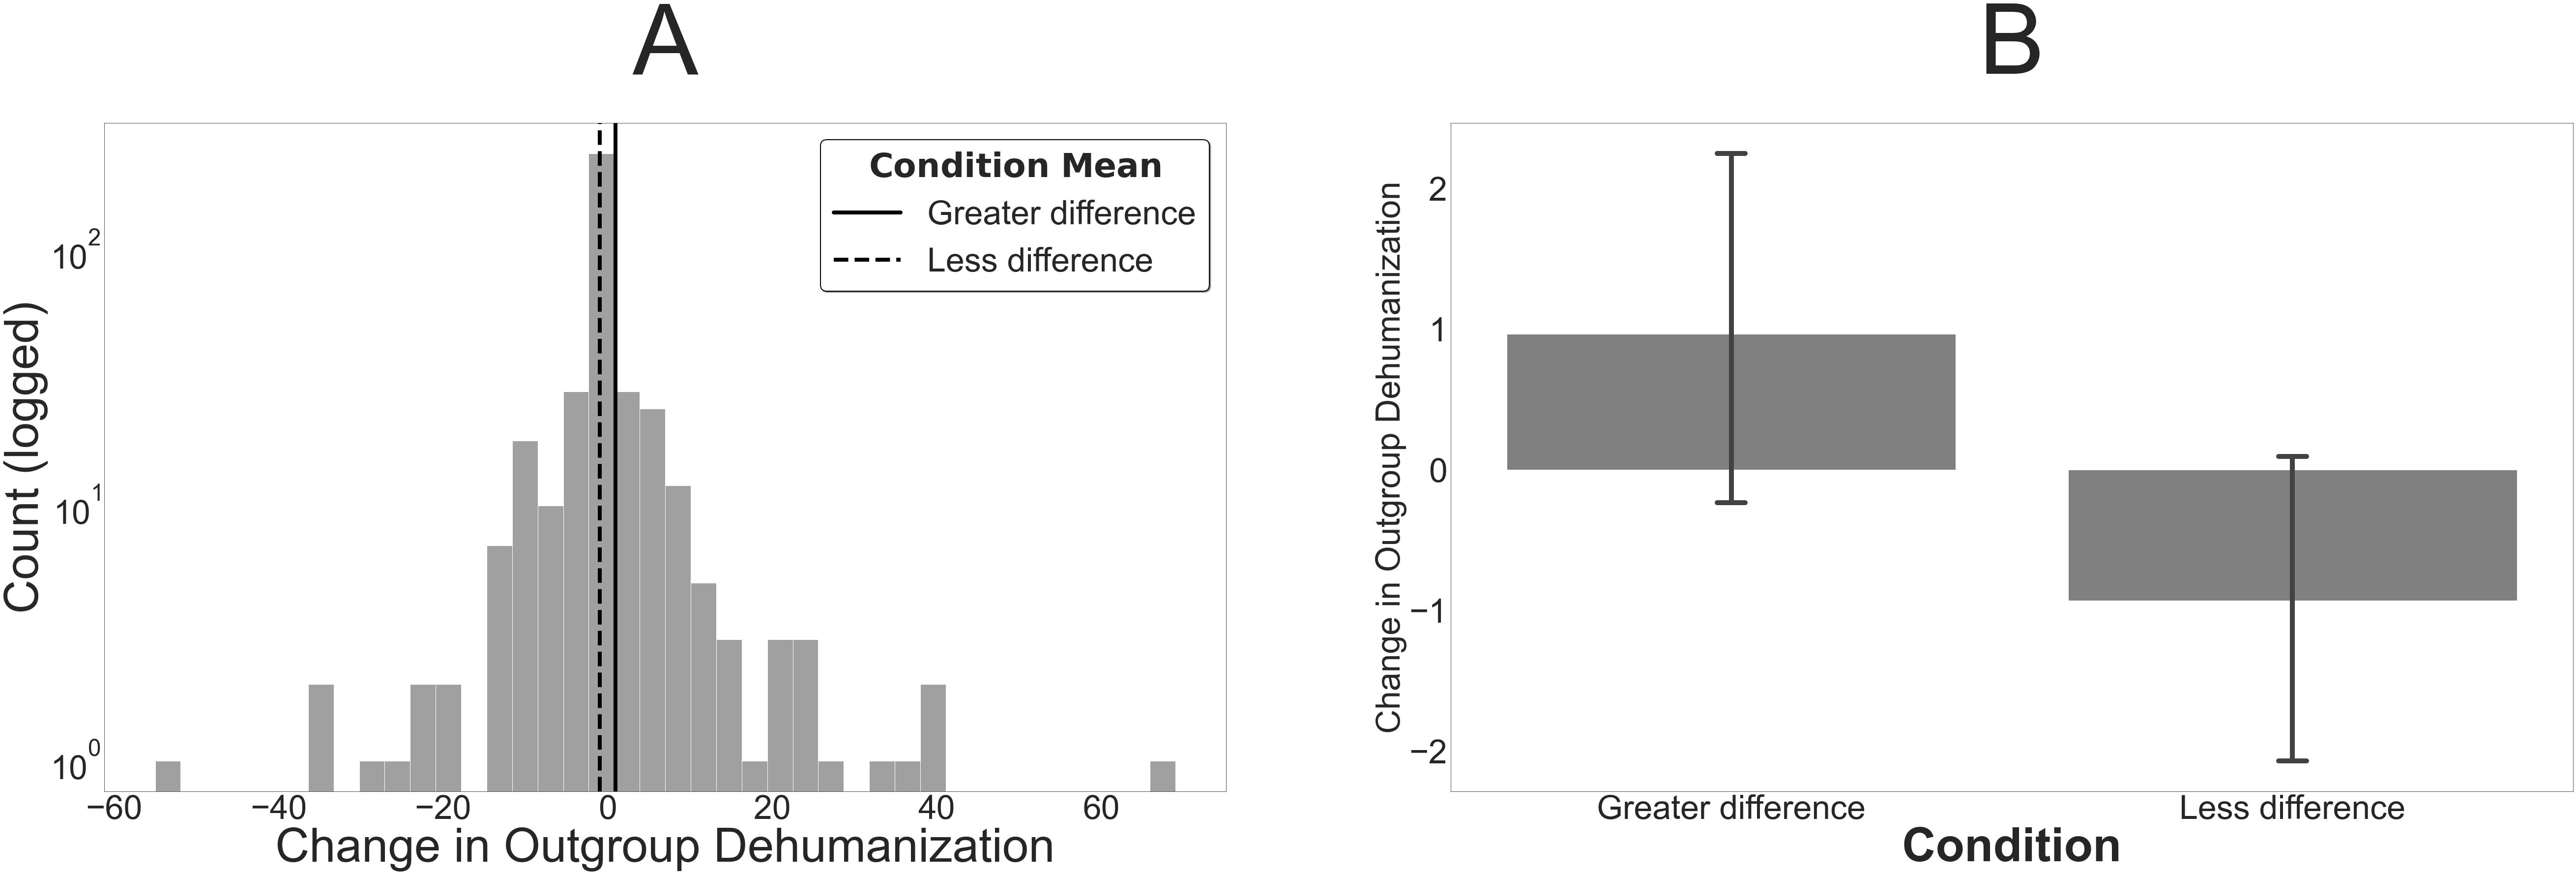

In [75]:
plt.rc('font', size=68) 
sb.set_style('white')
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(90,25))

axes[0].set_title('A',fontsize=200, pad=100)
sb.histplot(ax=axes[0], x="delta_dehuman",data=df2, bins=40, 
            legend=False, color="grey")
axes[0].axvline(df2[df2.high == 1].delta_dehuman.mean(), label="High Othering", color="black", lw=8)
axes[0].axvline(df2[df2.high == 0].delta_dehuman.mean(), label="Low Othering", ls="--", color="black", lw=8)
leg = axes[0].legend(title=r"$\bf{Condition\ Mean}$", loc='upper right', labels=['Greater difference', 'Less difference'],
                    fancybox=True, shadow=True, edgecolor="black")
leg.get_frame().set_linewidth(2)
axes[0].set_yscale("log")
axes[0].set_xlabel("Change in Outgroup Dehumanization", fontsize=96)
axes[0].set_ylabel("Count (logged)", fontsize=96)


axes[1].set_title('B',fontsize=200, pad=100)
sb.barplot(ax=axes[1], x='cond', y='delta_dehuman', data=df2,
          errwidth=10,capsize=0.05, color="grey")
axes[1].set_ylabel("Change in Outgroup Dehumanization", fontsize=68)
axes[1].set_xlabel("Condition", fontsize=96, fontweight="bold")
axes[1].set_xticks([0,1],['More difference', 'Less difference'])
axes[1].set_xticklabels(['Greater difference', 'Less difference'])
plt.show()

In [73]:
df2[df2.high==1].delta_dehuman.mean() - df2[df2.high==0].delta_dehuman.mean()

1.89481526378261